/usr/local/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [13:10:57] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


모델 학습 완료!
Global SHAP 값 계산 중... (잠시만 기다려주세요)

[전사 퇴사 위험 핵심 요인 (Global View)]


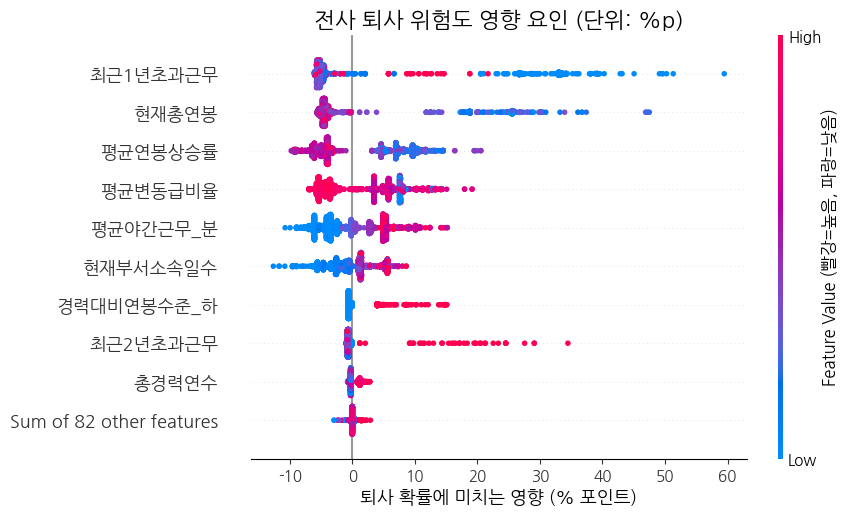

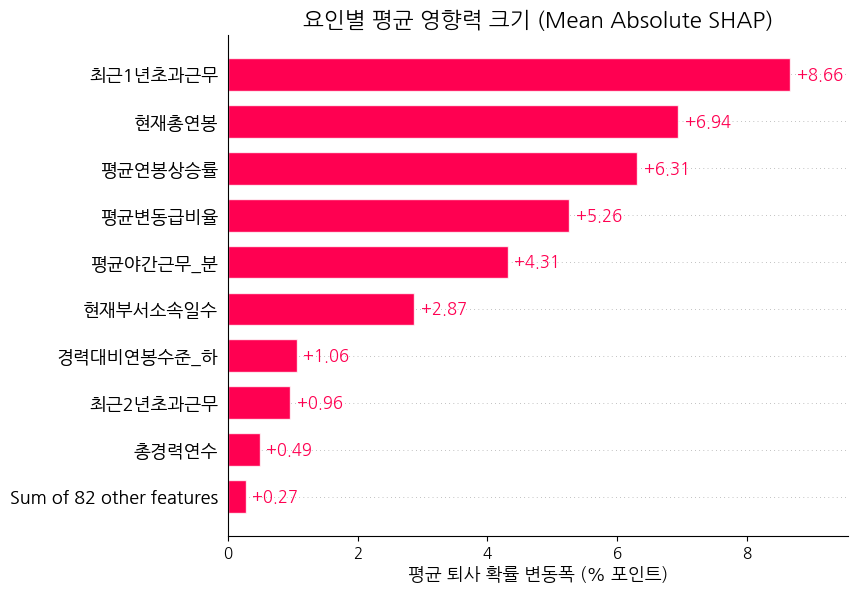


[심층 분석] 가장 영향력이 큰 변수: '최근1년초과근무' 의존성 분석


<Figure size 1000x600 with 0 Axes>

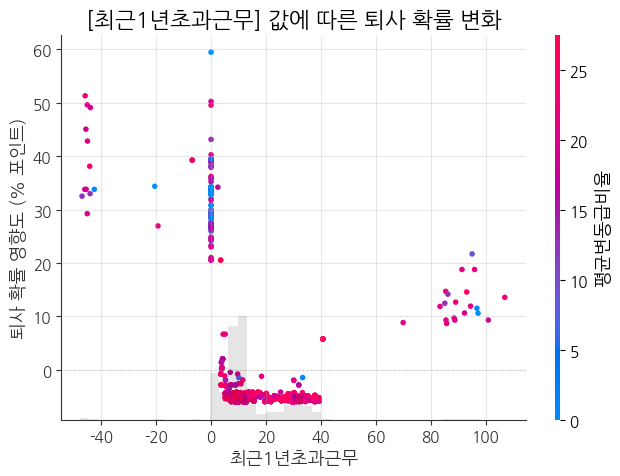

In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
import shap
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

from services.tables.create_ml_table import master_df_encoded


# --- 1. 한글 폰트 설정 ---
def set_korean_font():
    font_names = [f.name for f in fm.fontManager.ttflist]
    if 'NanumGothic' in font_names:
        plt.rcParams['font.family'] = 'NanumGothic'
    elif 'Malgun Gothic' in font_names:
        plt.rcParams['font.family'] = 'Malgun Gothic'
    elif 'AppleGothic' in font_names:
        plt.rcParams['font.family'] = 'AppleGothic'
    else:
        plt.rcParams['font.family'] = 'DejaVu Sans'

set_korean_font()
plt.rcParams['axes.unicode_minus'] = False

# --- 2. 데이터 준비 & 전처리 (이전과 동일) ---

# 데이터 타입 정리
for col in master_df_encoded.columns:
    if master_df_encoded[col].dtype == 'object' and col not in ['사번', '재직여부', '퇴사자여부']:
        master_df_encoded[col] = pd.to_numeric(master_df_encoded[col], errors='coerce')
master_df_encoded.fillna(master_df_encoded.median(numeric_only=True), inplace=True)

# --- 3. 데이터 비율 9:1 조정 ---
df_leavers = master_df_encoded[master_df_encoded['퇴사자여부'] == 1]
df_active = master_df_encoded[master_df_encoded['퇴사자여부'] == 0]

n_leavers = len(df_leavers)
n_required_active = n_leavers * 6

# 재직자 뻥튀기 (Oversampling)
df_active_oversampled = df_active.sample(n=n_required_active, replace=True, random_state=42)
balanced_df = pd.concat([df_leavers, df_active_oversampled], axis=0).sample(frac=1, random_state=42).reset_index(drop=True)

drop_cols = ['사번', '재직여부', '퇴사자여부']
feature_cols = [col for col in balanced_df.columns if col not in drop_cols]

X_train = balanced_df[feature_cols].astype(float)
y_train = balanced_df['퇴사자여부'].astype(float)

# --- 4. 모델 학습 (가중치 10만 적용) ---
weight_ratio = 50  # (6:1 불균형을 상쇄할 만큼의 힘)

model = xgb.XGBClassifier(
    n_estimators=weight_ratio, 
    max_depth=2,             
    learning_rate=0.1, 
    scale_pos_weight=weight_ratio,  # <--- [핵심] 이 값이 높을수록 퇴사 확률이 높게 나옴
    random_state=42, 
    min_child_weight=10, 
    use_label_encoder=False, 
    eval_metric='logloss'
)
model.fit(X_train, y_train)
print("모델 학습 완료!")

# --- 5. Global SHAP 분석 ---
X_sample = X_train.sample(n=min(2000, len(X_train)), random_state=42)
background_data = shap.sample(X_train, 100)

explainer = shap.TreeExplainer(
    model, 
    data=background_data, 
    feature_perturbation="interventional",
    model_output="probability"
)

print("Global SHAP 값 계산 중... (잠시만 기다려주세요)")
shap_values_global = explainer(X_sample)

# --- 6. 단위 변환 (확률 -> 퍼센트) ---
shap_values_global.values = shap_values_global.values * 100
shap_values_global.base_values = shap_values_global.base_values * 100

# --- 7. 시각화 (Beeswarm Plot) ---
print("\n[전사 퇴사 위험 핵심 요인 (Global View)]")
plt.figure(figsize=(12, 8))
shap.plots.beeswarm(
    shap_values_global, 
    max_display=10,    
    show=False,
    color_bar_label="Feature Value (빨강=높음, 파랑=낮음)"
)
plt.title("전사 퇴사 위험도 영향 요인 (단위: %p)", fontsize=16)
plt.xlabel("퇴사 확률에 미치는 영향 (% 포인트)")
plt.show()

# --- 8. (옵션) 단순 중요도 Bar Plot ---
plt.figure(figsize=(10, 6))
shap.plots.bar(
    shap_values_global, 
    max_display=10, 
    show=False
)
plt.title("요인별 평균 영향력 크기 (Mean Absolute SHAP)", fontsize=16)
plt.xlabel("평균 퇴사 확률 변동폭 (% 포인트)")
plt.show()

# =============================================================================
# 🎨 [추가] SHAP Dependence Plot (Partial Dependence Plot 대체)
# =============================================================================
# 가장 중요한 변수(Top 1)를 자동으로 찾아서 상세 분석 그래프를 그립니다.
# (Y축: 해당 변수가 퇴사 확률을 얼마나 높이고 낮췄는지 보여줌)

# 1. 가장 중요한 변수 이름 찾기
# (평균 절대 SHAP 값이 가장 큰 변수)
top_feature_idx = np.abs(shap_values_global.values).mean(0).argmax()
top_feature_name = shap_values_global.feature_names[top_feature_idx]

print(f"\n[심층 분석] 가장 영향력이 큰 변수: '{top_feature_name}' 의존성 분석")

# 2. Dependence Plot 그리기
# color=shap_values_global은 자동으로 상호작용(Interaction)이 강한 다른 변수로 색상을 입혀줍니다.
plt.figure(figsize=(10, 6))
shap.plots.scatter(
    shap_values_global[:, top_feature_name], 
    color=shap_values_global, 
    show=False
)

plt.title(f"[{top_feature_name}] 값에 따른 퇴사 확률 변화", fontsize=16)
plt.ylabel("퇴사 확률 영향도 (% 포인트)")
plt.grid(True, alpha=0.3)
plt.show()

📊 그래프 해석 가이드: 3가지 포인트만 기억하세요!
1. 무엇이 가장 중요한가요? (Y축)

맨 위에 있는 항목일수록 퇴사 여부를 결정짓는 가장 강력한 요인입니다.

2. 색깔은 무엇을 의미하나요? (Color)

🔴 빨간색: 수치가 높음 (High) (예: 야근 많음, 고연차)

🔵 파란색: 수치가 낮음 (Low) (예: 야근 적음, 저연차)

3. 오른쪽인가요, 왼쪽인가요? (X축)

👉 오른쪽 (+): 퇴사 확률을 높임 (위험 ⚠️)

👈 왼쪽 (-): 퇴사 확률을 낮춤 (안전 ✅)

예시: **"야근 시간"**이 **빨간색(🔴)**인데 **오른쪽(👉)**에 있다면? *"야근을 많이 할수록 퇴사 위험이 높아진다"*는 뜻입니다.